In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import math
from datetime import timedelta, datetime

# Bad Predictions, OK EVAL Metrics, Work on Prediciton function

ImportError: DLL load failed while importing _path: The specified module could not be found.

In [ ]:
def prepare_lstm_data(df, target_col='Close', sequence_length=60):
    """
    Prepare data for LSTM model by creating sequences
    
    Parameters:
    df (DataFrame): Input dataframe with features
    target_col (str): Column to predict
    sequence_length (int): Number of time steps to use for sequences
    
    Returns:
    tuple: (X_train, y_train, X_test, y_test, scalers)
    """
    print("\n==== Preparing Data for LSTM Model ====")
    
    # Get list of features to use (numeric columns)
    feature_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Remove any derived features that use future information to avoid data leakage
    features_to_exclude = [
        'price_change_pct', 'price_change', 'returns',  # These are based on future Close prices
        'momentum_5d', 'momentum_10d', 'momentum_20d'   # These look ahead in time
    ]
    
    feature_columns = [col for col in feature_columns if col not in features_to_exclude]
    
    # Make sure target is in features
    if target_col not in feature_columns:
        feature_columns.append(target_col)
    
    print(f"Using {len(feature_columns)} features: {feature_columns[:5]}...")
    
    # Create a new dataframe with selected features, dropping NaN rows
    data = df[feature_columns].dropna()
    
    # Split into training and test sets (70% train, 30% test)
    train_size = int(len(data) * 0.7)
    train_data = data.iloc[:train_size]
    test_data = data.iloc[train_size:]
    
    print(f"Train data shape: {train_data.shape}, Test data shape: {test_data.shape}")
    
    # Normalize the data - store scalers for later inverse transformation
    scalers = {}
    train_scaled = pd.DataFrame()
    test_scaled = pd.DataFrame()
    
    for column in feature_columns:
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Fit scaler on training data
        train_scaled[column] = scaler.fit_transform(train_data[column].values.reshape(-1, 1)).flatten()
        # Transform test data with the same scaler
        test_scaled[column] = scaler.transform(test_data[column].values.reshape(-1, 1)).flatten()
        # Store scaler for inverse transformation later
        scalers[column] = scaler

    # Create sequences for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            # Extract sequence of features
            seq_x = data.iloc[i:(i + seq_length)].values
            # Extract target
            seq_y = data.iloc[i + seq_length][target_col]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    
    # Generate training sequences
    X_train, y_train = create_sequences(train_scaled, sequence_length)
    # Generate test sequences
    X_test, y_test = create_sequences(test_scaled, sequence_length)
    
    print(f"Training sequences shape: {X_train.shape}")
    print(f"Test sequences shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test, scalers, feature_columns


==== Preparing Data for LSTM Model ====
Using 31 features: ['calendarYear', 'revenue', 'grossProfit', 'netIncome', 'operatingIncome']...
Train data shape: (889, 31), Test data shape: (381, 31)
Training sequences shape: (769, 120, 31)
Test sequences shape: (261, 120, 31)

==== Training LSTM Model ====
Epoch 1/25


c:\Users\lukis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 0.1499 - val_loss: 5.2529
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0979 - val_loss: 4.6152
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0831 - val_loss: 4.3988
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0749 - val_loss: 4.0791
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0650 - val_loss: 3.7958
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0560 - val_loss: 3.3716
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0488 - val_loss: 3.1700
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0435 - val_loss: 3.2106
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0403 - val_loss: 3.0403
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0352 - val_loss: 2.8783
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0324 - val_loss: 2.6164
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0311 - val_l

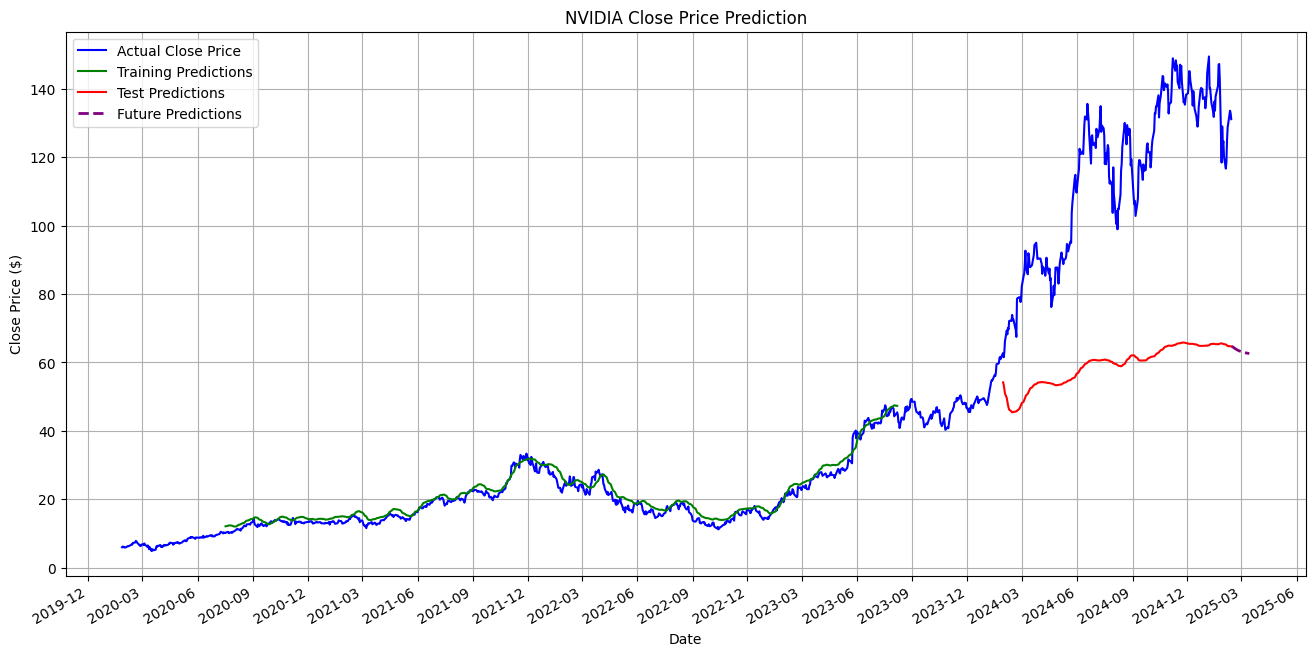

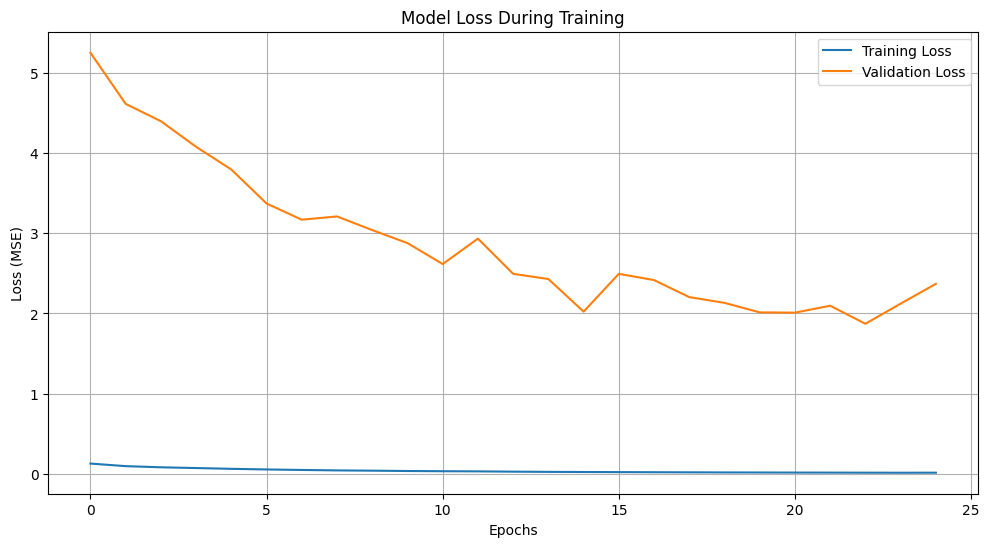

Model saved as 'nvidia_lstm_model.h5'
Combined historical and future predictions saved to 'nvidia_historical_and_future.csv'

==== Prediction Complete ====
Model metrics: {'train_rmse': 1.7848339045984414, 'test_rmse': 58.086742079969355, 'train_mae': 1.4827146096099337, 'test_mae': 55.23437084914167, 'train_r2': 0.9515339559251038, 'test_r2': -5.315749813100116}
Test predictions shape: (261, 1)
Future predictions shape: (30, 1)
Predicted 30 days into the future


In [ ]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=input_shape, 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Add L2 regularization
    model.add(Dropout(0.3))  # Increase dropout
    model.add(LSTM(units=32, return_sequences=False, 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(units=16))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    """
    Train the LSTM model
    
    Parameters:
    X_train, y_train, X_test, y_test: Training and test data
    epochs (int): Number of training epochs
    batch_size (int): Training batch size
    
    Returns:
    model: Trained model
    history: Training history
    """
    print("\n==== Training LSTM Model ====")
    
    # Get input shape from training data
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape)
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1
    )
    
    return model, history

def evaluate_model(model, X_train, y_train, X_test, y_test, scalers, target_col='Close'):
    """
    Evaluate the LSTM model performance
    
    Parameters:
    model: Trained LSTM model
    X_train, y_train, X_test, y_test: Training and test data
    scalers (dict): Dictionary of scalers for each feature
    target_col (str): Target column name
    
    Returns:
    tuple: (train_predictions, test_predictions, metrics)
    """
    print("\n==== Evaluating Model Performance ====")
    
    # Get target scaler for inverse transformation
    scaler = scalers[target_col]
    
    # Make predictions
    train_predictions_scaled = model.predict(X_train)
    test_predictions_scaled = model.predict(X_test)
    
    # Inverse transform predictions and actual values to original scale
    train_predictions = scaler.inverse_transform(train_predictions_scaled)
    test_predictions = scaler.inverse_transform(test_predictions_scaled)
    
    # Transform the original y values back to original scale
    y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate metrics - make sure arrays are the same length
    train_rmse = math.sqrt(mean_squared_error(y_train_orig, train_predictions))
    test_rmse = math.sqrt(mean_squared_error(y_test_orig, test_predictions))
    
    train_mae = mean_absolute_error(y_train_orig, train_predictions)
    test_mae = mean_absolute_error(y_test_orig, test_predictions)
    
    train_r2 = r2_score(y_train_orig, train_predictions)
    test_r2 = r2_score(y_test_orig, test_predictions)
    
    # Store metrics in dictionary
    metrics = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    # Print metrics
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Training MAE: {train_mae:.2f}")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    
    return train_predictions, test_predictions, metrics

def visualize_predictions(df, train_predictions, test_predictions, future_predictions=None, future_dates=None, sequence_length=60, target_col='Close', history=None):
    """
    Visualize model predictions against actual prices, including future predictions
    
    Parameters:
    df (DataFrame): Original dataframe
    train_predictions, test_predictions: Model predictions
    future_predictions (array): Predictions for future dates
    future_dates (array): Future dates for predictions
    sequence_length (int): Sequence length used for LSTM
    target_col (str): Target column name
    history: Training history
    """
    print("\n==== Visualizing Predictions ====")
    
    plt.figure(figsize=(16, 8))
    
    # Plot actual data
    plt.plot(df.index, df[target_col], color='blue', label=f'Actual {target_col} Price')
    
    # Calculate indices for predictions
    train_size = int(len(df) * 0.7)
    
    # For training predictions: need to offset by sequence_length
    train_start_idx = sequence_length
    train_end_idx = train_size
    train_plot_indices = df.index[train_start_idx:train_end_idx]
    
    # For test predictions: need to start after train data
    test_start_idx = train_size + sequence_length
    test_end_idx = test_start_idx + len(test_predictions)
    
    # Make sure test_end_idx doesn't exceed dataframe length
    test_end_idx = min(test_end_idx, len(df))
    test_predictions = test_predictions[:test_end_idx - test_start_idx]  # Adjust predictions length
    
    test_plot_indices = df.index[test_start_idx:test_end_idx]
    
    # Plot predictions - only if we have valid indices
    if len(train_plot_indices) > 0 and len(train_predictions) > 0:
        # Make sure lengths match
        min_train_len = min(len(train_plot_indices), len(train_predictions))
        plt.plot(train_plot_indices[:min_train_len], train_predictions[:min_train_len].flatten(), 
                 color='green', label=f'Training Predictions')
    
    if len(test_plot_indices) > 0 and len(test_predictions) > 0:
        # Make sure lengths match
        min_test_len = min(len(test_plot_indices), len(test_predictions))
        plt.plot(test_plot_indices[:min_test_len], test_predictions[:min_test_len].flatten(), 
                 color='red', label=f'Test Predictions')
    
    # Plot future predictions if available
    if future_predictions is not None and future_dates is not None:
        plt.plot(future_dates, future_predictions.flatten(), color='purple', linestyle='--', linewidth=2, 
                label=f'Future Predictions')
    
    plt.title(f'NVIDIA {target_col} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel(f'{target_col} Price ($)')
    plt.legend()
    plt.grid(True)
    
    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()
    
    plt.savefig('nvidia_stock_prediction_with_future.png')
    plt.show()
    
    # Plot loss during training if history is available
    if history is not None:
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss During Training')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (MSE)')
        plt.legend()
        plt.grid(True)
        
        plt.savefig('nvidia_training_loss.png')
        plt.show()

def predict_future(model, df, scalers, feature_columns, target_col='Close', sequence_length=60, days_to_predict=365):
    """
    Predict future values using the trained LSTM model
    
    Parameters:
    model: Trained LSTM model
    df (DataFrame): Original dataframe with features
    scalers (dict): Dictionary of scalers for each feature
    feature_columns (list): List of feature column names
    target_col (str): Target column name to predict
    sequence_length (int): Number of time steps for sequences
    days_to_predict (int): Number of days to predict into the future
    
    Returns:
    tuple: (future_predictions, future_dates)
    """
    print(f"\n==== Predicting {days_to_predict} Days into the Future ====")
    
    # Create a copy of the last sequence_length records for prediction
    latest_data = df[feature_columns].tail(sequence_length).copy()
    
    # Scale the data using the saved scalers
    latest_data_scaled = pd.DataFrame()
    for column in feature_columns:
        scaler = scalers[column]
        latest_data_scaled[column] = scaler.transform(latest_data[column].values.reshape(-1, 1)).flatten()
    
    # Get target scaler for inverse transform
    target_scaler = scalers[target_col]
    
    # Generate future dates
    last_date = df.index[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(days_to_predict)]
    
    # Make future predictions one day at a time
    future_predictions = []
    
    # Create a copy of the latest data for prediction
    current_sequence = latest_data_scaled.values.copy()
    
    for i in range(days_to_predict):
        # Reshape for LSTM model (samples, time steps, features)
        X_pred = current_sequence.reshape(1, sequence_length, len(feature_columns))
        
        # Predict next day
        next_day_scaled = model.predict(X_pred)
        
        # Inverse transform to get actual price
        next_day_price = target_scaler.inverse_transform(next_day_scaled)
        future_predictions.append(next_day_price[0, 0])
        
        # For the next iteration, update the sequence by removing the first row and adding the new prediction
        # We need to create a new row with all features
        new_row = np.zeros(len(feature_columns))
        
        # Set the target value to the predicted value
        target_idx = feature_columns.index(target_col)
        new_row[target_idx] = next_day_scaled[0, 0]
        
        # For simplicity, we'll use the last known values for other features
        # In a more sophisticated model, you might want to predict these features as well
        for j, col in enumerate(feature_columns):
            if col != target_col:
                new_row[j] = current_sequence[-1, j]
        
        # Update the sequence: remove first row and add new prediction
        current_sequence = np.vstack([current_sequence[1:], new_row])
    
    # Convert future predictions to numpy array
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    
    # Create a dataframe with future predictions
    future_df = pd.DataFrame({
        'Date': future_dates,
        f'Predicted_{target_col}': future_predictions.flatten()
    })
    future_df.set_index('Date', inplace=True)
    
    # Save future predictions to CSV
    future_df.to_csv('nvidia_future_predictions.csv')
    print(f"Future predictions saved to 'nvidia_future_predictions.csv'")
    
    return future_predictions, future_dates

def predict_lstm(df, target_col='Close', sequence_length=60, epochs=50, batch_size=32, predict_days=365):
    """
    Main function to run LSTM prediction on stock data and predict future values
    
    Parameters:
    df (DataFrame): Processed dataframe with features
    target_col (str): Column to predict (default: 'Close')
    sequence_length (int): Number of time steps for sequences (default: 60)
    epochs (int): Maximum training epochs (default: 50)
    batch_size (int): Training batch size (default: 32)
    predict_days (int): Number of days to predict into the future (default: 365)
    
    Returns:
    tuple: (model, metrics, predictions, future_predictions, future_dates)
    """
    # Prepare data
    X_train, y_train, X_test, y_test, scalers, feature_columns = prepare_lstm_data(
        df, target_col=target_col, sequence_length=sequence_length
    )
    
    # Train model
    model, history = train_lstm_model(
        X_train, y_train, X_test, y_test, 
        epochs=epochs, batch_size=batch_size
    )
    
    # Evaluate model
    train_predictions, test_predictions, metrics = evaluate_model(
        model, X_train, y_train, X_test, y_test, scalers, target_col
    )
    
    # Predict future values
    future_predictions, future_dates = predict_future(
        model, df, scalers, feature_columns,
        target_col=target_col, sequence_length=sequence_length, days_to_predict=predict_days
    )
    
    # Visualize results including future predictions
    visualize_predictions(
        df, train_predictions, test_predictions, 
        future_predictions, future_dates, 
        sequence_length, target_col, history
    )
    
    # Save model
    model.save('nvidia_lstm_model.h5')
    print("Model saved as 'nvidia_lstm_model.h5'")
    
    # Create a combined dataset with historical and future predictions
    historical_actual = df[[target_col]].copy()
    historical_actual.columns = ['Actual_Close']
    
    # Create a dataframe for future predictions
    future_df = pd.DataFrame({
        'Predicted_Close': future_predictions.flatten()
    }, index=future_dates)
    
    # Combine historical and future data
    combined_df = pd.concat([historical_actual, future_df])
    combined_df.to_csv('nvidia_historical_and_future.csv')
    print("Combined historical and future predictions saved to 'nvidia_historical_and_future.csv'")
    
    return model, metrics, test_predictions, future_predictions, future_dates

# Example usage with the processed dataframe
if __name__ == "__main__":
    # Load the data
    enhanced_df = pd.read_csv("nvda_merged_dataset.csv")
    
    # Convert Date to datetime and set as index
    enhanced_df['Date'] = pd.to_datetime(enhanced_df['Date'])
    enhanced_df.set_index('Date', inplace=True)
    
    # Run LSTM prediction with future forecasting
    model, metrics, test_predictions, future_predictions, future_dates = predict_lstm(
        enhanced_df, 
        target_col='Close',
        sequence_length=120,  # 60 days of history
        epochs=25,
        batch_size=32,
        predict_days=30  # Predict one year into the future
    )
    
    print("\n==== Prediction Complete ====")
    print(f"Model metrics: {metrics}")
    print(f"Test predictions shape: {test_predictions.shape}")
    print(f"Future predictions shape: {future_predictions.shape}")
    print(f"Predicted {len(future_dates)} days into the future")

In [ ]:
# Potential changes

# 1. Modify the LSTM architecture to be less complex
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=input_shape, 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)))  # Add L2 regularization
    model.add(Dropout(0.3))  # Increase dropout
    model.add(LSTM(units=32, return_sequences=False, 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(units=16))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

    # Original Model
def build_lstm_model(input_shape):
    """
    Build LSTM model architecture
    
    Parameters:
    input_shape (tuple): Shape of input data (sequence_length, features)
    
    Returns:
    model: Compiled LSTM model
    """
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Dense layers for prediction
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    
    return model

# 2. Use log returns instead of raw prices
def prepare_log_returns(df, target_col='Close'):
    df['log_price'] = np.log(df[target_col])
    df['log_return'] = df['log_price'].diff()
    return df

# 3. More aggressive early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)